In [0]:
import gym
import random
import time
import pickle
import itertools
#from gym.envs.classic_control import rendering 

In [0]:
def repeat_upsample(rgb_array, k=1, l=1, err=[]):
    # repeat kinda crashes if k/l are zero
    if k <= 0 or l <= 0: 
        if not err: 
            print("Number of repeats must be larger than 0, k: {}, l: {}, returning default array!".format(k, l))
            err.append('logged')
        return rgb_array

    # repeat the pixels k times along the y axis and l times along the x axis
    # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

    return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

In [0]:
viewer_S = rendering.SimpleImageViewer()
viewer_A = rendering.SimpleImageViewer()
viewer_D = rendering.SimpleImageViewer()

In [0]:
env_S = gym.make('SpaceInvaders-v0')
print("Action Space: ", env_S.action_space)
print("Observation Space: ", env_S.observation_space)

Action Space:  Discrete(6)
Observation Space:  Box(210, 160, 3)


In [0]:
env_A = gym.make('Assault-v0')
print("Action Space: ", env_A.action_space)
print("Observation Space: ", env_A.observation_space)

Action Space:  Discrete(7)
Observation Space:  Box(250, 160, 3)


In [0]:
env_D = gym.make('DemonAttack-v0')
print("Action Space: ", env_D.action_space)
print("Observation Space: ", env_D.observation_space)

Action Space:  Discrete(6)
Observation Space:  Box(210, 160, 3)


In [0]:
class Agent_all():
    def __init__(self, env):
        # 0 = nothing, 1 = fire, 2 = right, 3 = left
        self.common_actions = [0, 1, 2, 3]
        self.assult_translation = {0:1, 1:2, 2:3, 3:4}
    
    def get_action(self, state):
        base_action = random.choice(self.common_actions)
        
        assault_action = self.assult_translation[base_action]
        
        return base_action, base_action, assault_action

In [0]:
state_S = env_S.reset()
state_A = env_A.reset()
state_D = env_D.reset()

In [0]:
agent = Agent_all(env_S)

for _ in range(2000):
    action_S, action_D, action_A = agent.get_action(state_S)
    
    state_S, reward_S, done_S, info_S = env_S.step(action_S)
    
    rgb_S = env_S.render('rgb_array')
    rgb_S = rgb_S[22:195, :, :]
    viewer_S.imshow(repeat_upsample(rgb_S, 3, 3))
    
    state_A, reward_A, done_A, info_A = env_A.step(action_A)
    
    rgb_A = env_A.render('rgb_array')
    rgb_A = rgb_A[51:195+29, :, :]
    viewer_A.imshow(repeat_upsample(rgb_A, 3, 3))
    
    state_D, reward_D, done_D, info_D = env_D.step(action_D)
    
    rgb_D = env_D.render('rgb_array')
    rgb_D = rgb_D[15:188, :, :]
    viewer_D.imshow(repeat_upsample(rgb_D, 3, 3))
    
    #time.sleep(0.1)
    if done_S & done_A & done_D:
        break
    
    

In [0]:
rgb_A.mean(axis=2).shape

(250, 160)

SI: 0 = nothing, 1 = fire, 2 = right, 3 = left, 4 = right + fire, 5 = left + fire  
A:  0 = nothing, 1 = nothing?, 2 = fire, 3 = right, 4 = left, 5 = shoot right, 6 = shoot left  
DA: 0 = nothing, 1 = fire, 2 = right, 3 = left, 4 = right + fire, 5 = left + fire  

# Tutorial
Full code, but using tensorflow
 - https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb  
 - https://www.youtube.com/watch?v=gCJyVX98KJ4

Using Pytorch
 - https://www.youtube.com/watch?v=RfNxXlO6BiA

Also
 - https://www.youtube.com/watch?v=dpBKz1wxE_c
 
Frame Skipping and Stacking
 - https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
 
General DQN Walkthrough =
 - https://medium.com/@jonathan_hui/rl-dqn-deep-q-network-e207751f7ae4

In [0]:
import numpy as np           # Handle matrices

from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

import matplotlib.pyplot as plt # Display graphs

from collections import deque# Ordered collection with ends

import random

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

In [0]:
import gym
import random
import time
import pickle

In [0]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
import atari_wrappers, wrappers

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [0]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, transition):
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        
        random_indices = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        sample = [self.buffer[i] for i in random_indices]
        
        
        return sample

In [0]:
def conv2d_size_out(size, kernel_size = 5, stride = 2):
    """
    Number of Linear input connections depends on output of conv2d layers
    and therefore the input image size, so compute it.
    """
    out_size = (size - (kernel_size - 1) - 1) // stride  + 1

    return out_size

In [0]:
class DQN(nn.Module):

    def __init__(self, frame_shape, num_outputs, alpha):
        super(DQN, self).__init__()
        self.alpha = alpha
        
        h, w, d = frame_shape
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4) #32 filters, 8x8, stride 4
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) 
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        self.linear_input_size = convw * convh * 64
        
        self.fc1 = nn.Linear(self.linear_input_size, 512)
        self.fc2 = nn.Linear(512, num_outputs)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, betas=(0.95, 0.95), eps=0.01) # from the google paper
        self.loss = nn.MSELoss()
        

    # Called with either one element to determine next action, or a batch
    # during optimization.
    def forward(self, x):
        batch_shape = x.shape
        x = x/255.0
        
        # Must transpose it - comes in as (h, w, frames). Change to (frames, h, w)
        x = x.view(batch_shape[0], batch_shape[3], batch_shape[1], batch_shape[2])

        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Flatten 
        x = x.view(-1, self.linear_input_size)
        
        # Linear layers
        x = F.relu(self.fc1(x))
        q_vals = self.fc2(x)
        
        # q_vals is a q value for each action for each item in minibatch (Eg: 32 * 4)
        
        return q_vals


In [0]:
class Agent(object):
    
    def __init__(self, frame_shape, gamma, epsilon_start, epsilon_end, epsilon_decay, 
                 alpha, max_memory, replace, action_space):
        self.gamma = gamma # Discount factor
        self.epsilon_start = epsilon_start # For greedy action selection
        self.epsilon_end = epsilon_end #How low epsilon can go
        self.epsilon_decay = epsilon_decay
        self.replace = replace # How often to replace target network
        self.action_space = action_space
        self.n_actions = len(action_space)
        
        self.steps = 0
        self.learn_step_counter = 0 #How many times we've called learn function - For target network replacement
        self.memory = Memory(max_memory)
        
        self.replace_target = replace
        
        self.Q_eval = DQN(frame_shape, len(action_space), alpha) # Agent's estimate of current set of states' Q
        self.Q_next = DQN(frame_shape, len(action_space), alpha) # Agent's estimage of next set of states' Q
        
        self.action_values = T.Tensor(action_space).to(self.Q_eval.device)
        
        
    def storeTransition(self, state, action, reward, result_state, done):
        """
        Wrap the inputs into a "Transition" and puts in in memory 
        """
        transition = (state, action, reward, result_state, done)
        self.memory.add(transition)
        
        
    def chooseAction(self, observation, explore_bool=True):
        """
        Epsilon Greedy strategy with decaying exploration prob.
        """
        rand = np.random.rand()
        
        if not explore_bool:
            explore_probability = 0
            
        else:
            # Lower the exploration probability over time in accordance with 
            #  the number of times the model has learned 
            explore_probability = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                                  np.exp(-self.epsilon_decay * self.learn_step_counter)
        
        if rand < explore_probability:
            action = np.random.choice(self.action_space)
            
        else:
            observation = T.Tensor(np.array(observation)).unsqueeze(0).to(self.Q_eval.device)
            actions_pred = self.Q_eval.forward(observation)
                 
            # Take first axis because actions returned as a matrix (1 x num_actions) 
            action = T.argmax(actions_pred[0]).item()
            
        self.steps += 1
            
        return action, explore_probability
    
    
    def initial_fill_mem(self, env, pretrain_length, episode_render, obs_shape):
        """
        Start filling the memory of the agent with a bunch of random moves and transitions to start learning from.
        """    
        state = env.reset()

        for i in range(pretrain_length):

            # Get the next_state and the reward, done by taking a random action
            action = np.random.choice(self.action_space)
            next_state, reward, done, info = env.step(action)

            if episode_render: env.render()

            # If the episode is finished (we're dead 3x), then store a 0 next state and restart the env.
            if not done:
                # Add experience to memory
                self.storeTransition(state, action, reward, next_state, done)

                # Our new state is now the next_state
                state = next_state
                
            else: 
                # We finished the episode, add a state of all black
                next_state = np.zeros(obs_shape)

                # Add experience to memory
                self.storeTransition(state, action, reward, next_state, done)

                # Start a new episode
                state = env.reset()
                
                
    def run_episode(self, env, learn_bool, explore_bool, max_steps, obs_shape, batch_size, episode_render, train_every):
        """
        Run a single episode
        """
        # Make a new episode and observe the first state
        state = env.reset()
        episode_reward = 0
        episode_steps = 0
        episode_losses = []
        
        done = False

        while (episode_steps < max_steps) & (~done):
            episode_steps += 1

            # Predict the action to take and take it
            action, explore_probability = agent.chooseAction(state, explore_bool)

            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, info = env.step(action)

            if episode_render: env.render()

            # Add the reward to total reward
            episode_reward += reward

            # If it terminated, add a blank screen as the next state
            if done: next_state = np.zeros(obs_shape, dtype=np.int)

            # Add experience to memory
            self.storeTransition(state, action, reward, next_state, done)

            # st+1 is now our current state
            state = next_state

            ### LEARNING PART  
            if learn_bool & (episode_steps % train_every == 0): # Learn every 4 steps
                loss = agent.learn(batch_size)
                episode_losses.append(loss)


        # Get the mean loss of the episode
        mean_loss = sum(episode_losses)/len(episode_losses)

        print('Episode: {}'.format(episode),
              'Total reward: {}'.format(episode_reward),
              'Explore P: {:.4f}'.format(explore_probability),
              'Mean Training Loss {:.4f}'.format(mean_loss))
        
        return episode_reward, mean_loss, explore_probability
    
    
    def learn(self, batch_size):
        """
        Batch learn
        """
        # Zero gradients for next batch
        self.Q_eval.optimizer.zero_grad()
        
        # Target network replacement
        if self.replace_target is not None:
            if self.learn_step_counter % self.replace_target == 0:
                print('replacing target')
                self.Q_next.load_state_dict(self.Q_eval.state_dict())
            
        # Get a minibatch
        minibatch = self.memory.sample(batch_size)
        
        batch_states =   T.stack([T.Tensor(np.array(i[0])).to(self.Q_eval.device) for i in minibatch])
        batch_actions =  T.LongTensor([i[1] for i in minibatch]).to(self.Q_eval.device)
        batch_rewards =  T.Tensor([i[2] for i in minibatch]).to(self.Q_eval.device)
        batch_next_states = T.stack([T.Tensor(np.array(i[3])).to(self.Q_eval.device) for i in minibatch])
        done_bools =  T.Tensor([i[4] for i in minibatch]).to(self.Q_eval.device)
        
        batch_index = T.arange(batch_size, dtype=T.long, device=self.Q_eval.device)
        
        # Get predictions from both networks
        Qpred  = self.Q_eval.forward(batch_states).to(self.Q_eval.device)
        target = self.Q_eval.forward(batch_states).to(self.Q_eval.device)
        Qnext = self.Q_next.forward(batch_next_states).to(self.Q_next.device)
        
        target[batch_index, batch_actions] = batch_rewards + \
              self.gamma*T.max(Qnext, dim=1)[0]*done_bools
      
        
        # Get loss and backprob
        loss = self.Q_eval.loss(target, Qpred).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.learn_step_counter += 1
        
        return loss.item()
        

### Running

In [0]:
### MODEL HYPERPARAMETERS
alpha =  0.00025                   # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 1000           # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 32                # Batch size
target_net_replace = 10000     # Target network replacement
train_every = 4

# Exploration parameters for epsilon greedy strategy
epsilon_start = 1.0            # exploration probability at start
epsilon_end = 0.1            # minimum exploration probability 
epsilon_decay = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.99                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length =  50000         # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000           # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

In [18]:
# Create our environment
#env = atari_wrappers.make_atari('SpaceInvadersNoFrameskip-v0', max_steps)
env = atari_wrappers.make_atari('PongNoFrameskip-v0', max_steps)
env = atari_wrappers.wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False)

action_space = range(env.action_space.n)
obs_shape = env.observation_space.shape

print("Action Space: ", action_space)
print("Observation Space: ", obs_shape)


Action Space:  range(0, 6)
Observation Space:  (84, 84, 4)


In [0]:
agent = Agent(obs_shape, gamma, epsilon_start, epsilon_end, epsilon_decay, 
              alpha, memory_size, target_net_replace, action_space)

In [20]:
agent.Q_eval.device

device(type='cuda', index=0)

In [0]:
agent.initial_fill_mem(env, pretrain_length, episode_render, obs_shape)

AxesImage(72,36;446.4x217.44)
AxesImage(72,36;446.4x217.44)


(0, 0.0)

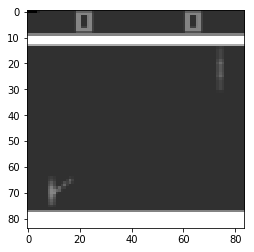

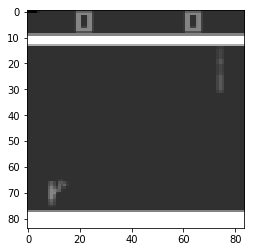

In [22]:
mem_element = -5

fig=plt.figure(figsize=(8, 4))
print(plt.imshow(np.array(agent.memory.buffer[mem_element][0]).sum(axis=2), cmap=plt.cm.gray))
fig=plt.figure(figsize=(8, 4))
print(plt.imshow(np.array(agent.memory.buffer[mem_element][3]).sum(axis=2), cmap=plt.cm.gray))
agent.memory.buffer[mem_element][1], agent.memory.buffer[mem_element][2]

replacing target
Episode: 0 Total reward: -21.0 Explore P: 0.9980 Mean Training Loss 0.0045
Episode: 1 Total reward: -21.0 Explore P: 0.9960 Mean Training Loss 0.0040
Episode: 2 Total reward: -20.0 Explore P: 0.9937 Mean Training Loss 0.0032
Episode: 3 Total reward: -20.0 Explore P: 0.9916 Mean Training Loss 0.0037
Episode: 4 Total reward: -21.0 Explore P: 0.9897 Mean Training Loss 0.0029
Episode: 5 Total reward: -20.0 Explore P: 0.9871 Mean Training Loss 0.0030
Episode: 6 Total reward: -20.0 Explore P: 0.9848 Mean Training Loss 0.0025
Episode: 7 Total reward: -19.0 Explore P: 0.9824 Mean Training Loss 0.0020
Episode: 8 Total reward: -21.0 Explore P: 0.9803 Mean Training Loss 0.0023
Episode: 9 Total reward: -21.0 Explore P: 0.9785 Mean Training Loss 0.0023
Episode: 10 Total reward: -21.0 Explore P: 0.9767 Mean Training Loss 0.0018


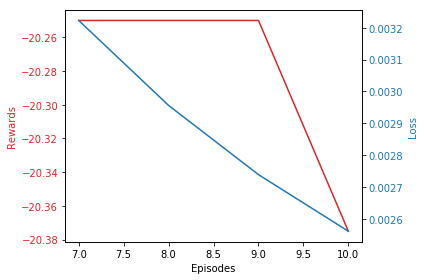

Episode: 11 Total reward: -21.0 Explore P: 0.9744 Mean Training Loss 0.0020
Episode: 12 Total reward: -21.0 Explore P: 0.9726 Mean Training Loss 0.0015
Episode: 13 Total reward: -21.0 Explore P: 0.9706 Mean Training Loss 0.0016
Episode: 14 Total reward: -21.0 Explore P: 0.9687 Mean Training Loss 0.0014
Episode: 15 Total reward: -20.0 Explore P: 0.9666 Mean Training Loss 0.0010
Episode: 16 Total reward: -21.0 Explore P: 0.9648 Mean Training Loss 0.0013
Episode: 17 Total reward: -19.0 Explore P: 0.9625 Mean Training Loss 0.0013
Episode: 18 Total reward: -21.0 Explore P: 0.9609 Mean Training Loss 0.0013
Episode: 19 Total reward: -20.0 Explore P: 0.9587 Mean Training Loss 0.0010
Episode: 20 Total reward: -21.0 Explore P: 0.9568 Mean Training Loss 0.0011


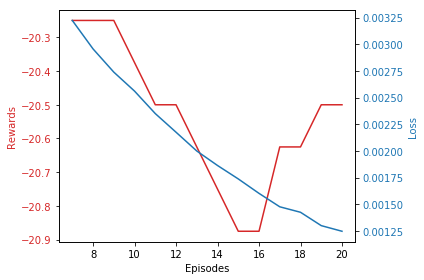

Episode: 21 Total reward: -20.0 Explore P: 0.9547 Mean Training Loss 0.0010
Episode: 22 Total reward: -21.0 Explore P: 0.9527 Mean Training Loss 0.0009
Episode: 23 Total reward: -20.0 Explore P: 0.9505 Mean Training Loss 0.0009
Episode: 24 Total reward: -21.0 Explore P: 0.9486 Mean Training Loss 0.0011


In [0]:
# Train the Model!
all_losses = []
all_rewards = []
explore_probs = []

for episode in range(total_episodes):

    episode_reward, mean_loss, explore_probability = agent.run_episode(env, True, True,
                                 max_steps,  obs_shape, batch_size, episode_render, train_every)
    
    all_losses.append(mean_loss)
    all_rewards.append(episode_reward)
    explore_probs.append(explore_probability)
    
    
    if (episode % 10 == 0) & (episode != 0):
        fig, ax1 = plt.subplots()
        avg_window = 8

        ax1.set_xlabel('Episodes')
        ax1.set_ylabel('Rewards', color='tab:red')
        ax1.plot(range(avg_window-1, episode+1), running_mean(all_rewards, avg_window), color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        ax2.set_ylabel('Loss', color='tab:blue')  # we already handled the x-label with ax1
        ax2.plot(range(avg_window-1, episode+1), running_mean(all_losses, avg_window), color='tab:blue')
        #ax2.plot(range(avg_window-1, episode+1), running_mean(explore_probs, avg_window))
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

In [0]:
with open('trained_new_loss.pkl', 'wb') as f:
    pickle.dump(agent, f)

In [0]:
with open('trained.pkl', 'rb') as f:
    trained500 = pickle.load(f)